In [60]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)   
pd.set_option('display.max_colwidth', -1)

In [2]:
df=pd.read_table("/Users/markespina/Downloads/listings.csv", sep=',')

In [3]:
conn= sqlite3.connect('/Users/markespina/airbnb.db')

In [4]:
df.to_sql("listings", conn, if_exists="replace")

In [5]:
df2=pd.read_table("/Users/markespina/Downloads/calendar.csv", sep=',')

In [6]:
df2.to_sql("calendar", conn, if_exists='replace')

In [7]:
df3 = pd.read_table("/Users/markespina/Downloads/reviews.csv", sep=',')

In [9]:
df3.to_sql("reviews", conn, if_exists="replace")

In [10]:
pd.read_sql("""
            SELECT 
                 id, name, summary, max(price)
            FROM listings
            --Money field contain commas as thousand separator
            WHERE price like '%,%'
            """, conn)

,id,name,summary,max(price)
0,4684661,Charming quiet bohemian getaway!,None,"$8,400.00"


In [12]:
pd.read_sql("""
            SELECT 
                neighbourhood,
                COUNT(id) listings,
                AVG(review_scores_value) mean_value,
                AVG(review_scores_accuracy) mean_accuracy, 
                AVG(review_scores_rating) mean_rating
            FROM listings
            GROUP BY 1
            ORDER BY 2 DESC, 3 DESC
            LIMIT 10
            """, conn)

,neighbourhood,listings,mean_value,mean_accuracy,mean_rating
0,Richmond,281,9.842912,9.885496,97.568702
1,Northwest District,218,9.623762,9.856436,96.262376
2,None,211,9.654762,9.755952,95.809524
3,Concordia,198,9.827027,9.913514,97.702703
4,King,178,9.736527,9.838323,97.131737
5,Buckman,164,9.734694,9.816327,96.317568
6,Hosford-Abernethy,149,9.819444,9.923611,97.631944
7,Sunnyside,143,9.709924,9.877863,96.893130
8,Sellwood-Moreland,138,9.824000,9.920000,97.240000
9,Overlook,123,9.787611,9.938053,97.424779


## The Richmond neighborhood is the most popular based on number of listings. It also boasts an average rating of 97.568

In [129]:
pd.read_sql("""
WITH 
    seasons
    AS(
            SELECT 
                listing_id,
                available,
                CASE WHEN DATE(date) BETWEEN '2018-07-10' AND '2018-09-21' THEN 'SUMMER'
                     WHEN DATE(date) BETWEEN '2018-09-22' AND '2018-12-21' THEN 'FALL'
                     WHEN DATE(date) BETWEEN 2018-12-22 AND '2019-03-21' THEN 'WINTER'
                     WHEN DATE(date) BETWEEN 2019-03-22 AND '2019-06-21' THEN 'SPRING'
                     ELSE 'SUMMER' END season
            FROM calendar
            )
SELECT 
     s.season, COUNT(CASE WHEN s.available = 't' THEN 1 END) vacancies 
            FROM listings
            LEFT JOIN seasons s
            ON listings.id = s.listing_id
            GROUP BY 1
            ORDER BY 2 Desc
            """, conn)

,season,vacancies
0,FALL,218172
1,SUMMER,152236
2,WINTER,151904
3,SPRING,130970


## fall has the most vacancies for rent in portland

In [56]:
# What s the best time of year I rent an airbnb in the 5 neighborhood in PDX? 
df = pd.read_sql("""
WITH 
    seasons
    AS(
            SELECT 
                listing_id,
                date,
                available,
                CASE WHEN DATE(date) BETWEEN '2018-07-10' AND '2018-09-21' THEN 'SUMMER'
                     WHEN DATE(date) BETWEEN '2018-09-22' AND '2018-12-21' THEN 'FALL'
                     WHEN DATE(date) BETWEEN 2018-12-22 AND '2019-03-21' THEN 'WINTER'
                     WHEN DATE(date) BETWEEN 2019-03-22 AND '2019-06-21' THEN 'SPRING'
                     ELSE 'SUMMER' END season
            FROM calendar
            )
    SELECT  
            s.season time_of_year, 
            l.neighbourhood neighborhood, 
            SUM(CAST(SUBSTR(l.price, 2, 5) as FLOAT))/COUNT(DATE(s.Date)) daily_avg
            
                FROM listings l
                LEFT JOIN seasons s
                ON l.id = s.listing_id
                WHERE s.available ='t'
                GROUP BY 1, 2
                HAVING l.neighbourhood IN ('Richmond', 'Northwest District', 'Concordia','King', 'Buckman')
                ORDER BY 2 ASC, 3


            """, conn)

In [80]:
variables=globals()
neighborhoods= ['Richmond', 'Northwest District', 'Concordia','King', 'Buckman']
x=0
for name in neighborhoods:
    variables["df{0}".format(x)] = df[df.neighborhood==name]
    x+=1

In [83]:
df

,time_of_year,neighborhood,daily_avg
0,FALL,Buckman,125.710056
1,WINTER,Buckman,128.516081
2,SPRING,Buckman,132.278263
3,SUMMER,Buckman,138.025242
4,SUMMER,Concordia,105.833931
5,FALL,Concordia,106.964519
6,SPRING,Concordia,115.380923
7,WINTER,Concordia,115.679021
8,FALL,King,109.728491
9,WINTER,King,111.673962


Text(0,0.5,'Mean price per night USD')

<Figure size 576x576 with 0 Axes>

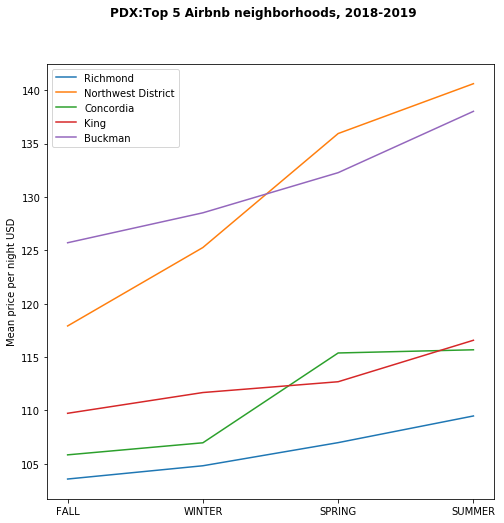

In [86]:
plt.figure(figsize=(8,8))
seasons=['FALL', 'WINTER', 'SPRING', 'SUMMER']
plt.figure(figsize=(8,8))
x=0
data=[df0,df1,df2,df3,df4]
for frame in data:
    plt.plot(seasons, frame['daily_avg'], label=neighborhoods[x])
    x+=1
plt.legend(loc='upper left')
plt.suptitle('PDX:Top 5 Airbnb neighborhoods, 2018-2019', fontweight='bold')
plt.ylabel('Mean price per night USD')